In [1]:
#Imports:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [2]:
df_orders = pd.read_csv("orders__dec_labeled.csv", sep = ",")
df_items = pd.read_csv("items.csv", sep = "|")
df_category = pd.read_csv("category_hierarchy.csv", sep = "|")

df_orders

,date,userID,itemID,order,label
0,2020-12-01,40058,860,1,0
1,2020-12-01,44334,11344,1,0
2,2020-12-01,17410,4049,1,0
3,2020-12-01,8713,25993,1,0
4,2020-12-01,12889,9376,1,0
...,...,...,...,...,...
138745,2020-12-31,3100,5768,1,0
138746,2020-12-31,11941,11798,2,0
138747,2020-12-31,1730,352,1,0
138748,2020-12-31,22593,18515,1,0


In [3]:
print(len(df_items['itemID'].unique()))
print(len(df_items))

32776
32776


In [4]:
result = pd.merge(df_orders, df_items, on="itemID")

In [5]:
result = result.drop(['categories'], axis = 1)
result = result.drop(['date'], axis = 1)

labels = result["label"]
data = result.drop(['label'], axis = 1)
data = result.drop(['order'], axis = 1)

data

,userID,itemID,label,brand,feature_1,feature_2,feature_3,feature_4,feature_5
0,40058,860,0,829,4,0,484,0,144
1,23826,860,0,829,4,0,484,0,144
2,37503,860,0,829,4,0,484,0,144
3,8638,860,0,829,4,0,484,0,144
4,44334,11344,0,177,10,0,503,0,122
...,...,...,...,...,...,...,...,...,...
138745,34906,21985,0,203,4,1,491,3,66
138746,15170,10084,0,1445,3,0,-1,-1,-1
138747,30587,9338,0,322,4,1,536,0,144
138748,30587,29204,0,342,6,1,232,0,122


In [6]:
enc = OneHotEncoder(handle_unknown='ignore')
cols = ["feature_1", "feature_2", "feature_4"]
encoder_df = pd.DataFrame(enc.fit_transform(data[cols]).toarray())
data = data[["userID", "itemID", "brand", "feature_3", "feature_5"]].join(encoder_df)


In [7]:
data

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,11,12,13,14,15,16,17,18,19,20
0,40058,860,829,484,144,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23826,860,829,484,144,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37503,860,829,484,144,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8638,860,829,484,144,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,44334,11344,177,503,122,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138745,34906,21985,203,491,66,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
138746,15170,10084,1445,-1,-1,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
138747,30587,9338,322,536,144,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
138748,30587,29204,342,232,122,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
#orders = np.array(orders)
data = np.array(data)
print(labels)
#lenc = LabelEncoder()
#lenc = lenc.fit(labels)
#labels = lenc.transform(labels)
#labels = np.array(labels).reshape(-1,1)

0         0
1         0
2         0
3         0
4         0
         ..
138745    0
138746    0
138747    0
138748    0
138749    0
Name: label, Length: 138750, dtype: int64


array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

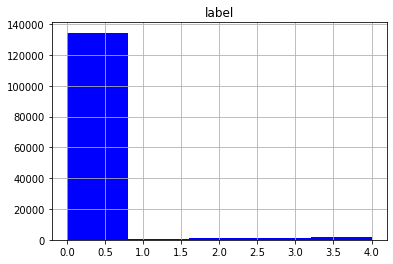

In [9]:
pd.DataFrame(labels).hist(bins=5,color='blue' )

In [10]:
X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.1, random_state=42)

In [11]:
X_train, X_val, y_train, y_val= train_test_split( X_train, y_train, test_size=0.1, random_state=42)

In [12]:
print(len(X_train.shape), len(X_test.shape), len(X_val.shape))
X_train.shape

2 2 2


(112387, 26)

In [13]:
y_train

82017     0
124830    0
109508    0
55836     0
89609     0
         ..
112224    0
106279    0
36226     0
95564     0
55841     0
Name: label, Length: 112387, dtype: int64

In [14]:
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.RegressionHead()],
    max_trials=5,
    overwrite = True
)


In [15]:
model.fit(
    x=X_train, y=y_train, epochs=100, batch_size=128, validation_data= [X_val, y_val]
)

Trial 5 Complete [00h 00m 39s]
val_loss: 0.29336175322532654

Best val_loss So Far: 0.2933548092842102
Total elapsed time: 00h 03m 58s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
879/879 [==============================] - 3s 2ms/step - loss: 0.3657 - mean_squared_error: 0.3657 - val_loss: 0.2955 - val_mean_squared_error: 0.2955
Epoch 2/100
879/879 [==============================] - 2s 2ms/step - loss: 0.2870 - mean_squared_error: 0.2870 - val_loss: 0.2940 - val_mean_squared_error: 0.2940
Epoch 3/100
879/879 [==============================] - 2s 2ms/step - loss: 0.2831 - mean_squared_error: 0.2831 - val_loss: 0.2937 - val_mean_squared_error: 0.2937
Epoch 4/100
879/879 [==============================] - 2s 2ms/step - loss: 0.2826 - mean_squared_error: 0.2826 - val_loss: 0.2937 - val_mean_squared_error: 0.2937
Epoch 5/100
879/879 [==============================] - 2s 2ms/step - loss: 0.2825 - mean_squared_error: 0.2825 - val_loss: 0.2936 - val_mean_squared_error: 0.2936
Epoch 6/100


In [16]:
model = model.export_model()


try:
    model.save("model_autokeras", save_format="tf")
except Exception:
    model.save("model_autokeras.h5")

INFO:tensorflow:Assets written to: model_autokeras/assets


In [ ]:
to_test = X_test
truth = y_test

res = np.round(model.predict(to_test))
info = pd.DataFrame(to_test)
stand = pd.DataFrame()
stand["userID"] = info[[0]]
stand["itemID"] = info[[1]]
pred = stand.copy()
gold = stand.copy()
pred["prediction"] = np.round(lenc.inverse_transform((res.astype(int))))
gold["prediction"] = np.round(truth)

In [ ]:
def count_points(pred, gold):
    df = pd.merge(pred, gold, on=['userID', 'itemID'], suffixes=('_pred', '_gold'))
    df['points'] = df.apply(_compute_points_for_row, axis=1)
    return df['points'].sum()

def _compute_points_for_row(row):
    y_pred, y_gold = row.prediction_pred, row.prediction_gold
    if y_pred == y_gold:
        # one point if "no order" (0) is predicted correctly; three points if order week is predicted correctly
        return 1 if y_pred == 0 else 3
    # one point if order is predicted correctly (but not the correct week), otherwise zero points
    return 1 if (y_pred > 0 and y_gold > 0) else 0

In [ ]:
points = count_points(pred, gold)
max_points = count_points(gold, gold)
score = points / max_points

In [ ]:
print(points)
print(max_points)
print(score)

In [ ]:
print(points)
print(max_points)
print(score)

In [ ]:
sns.set(style='darkgrid',font_scale=1.3, rc={'figure.figsize':(15,15)})
ax=pred["prediction"].hist(bins=2,color='blue' )